In [29]:
import torch 
import numpy as np

import math

import os
import pandas as pd
import geopandas as gpd
import pickle as pickle

import shapely
from shapely import wkt
from tqdm import tqdm

from joblib import Parallel, delayed

import trackintel as ti
from trackintel.geogr.distances import calculate_distance_matrix
from sklearn.preprocessing import OrdinalEncoder

import powerlaw

In [30]:
import matplotlib.pyplot as plt

colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

In [31]:
ti.__version__

'1.3.1'

In [32]:
from loc_predict.models.markov import markov_transition_prob
from utils.utils import load_data

def save_pk_file(save_path, data):
    """Function to save data to pickle format given data and path."""
    with open(save_path, "wb") as handle:
        pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Generate datasets

In [42]:
src_min_days = 7 * 2
src_max_days = 7 * 3

tgt_min_days = 7 * 1
# tgt_max_days = 7 * 2

data_type = "all"
level = 14

## Read staypoints and load with location id

In [43]:
sp = pd.read_csv(os.path.join(f"../data/sp_{data_type}.csv"), index_col="id")
loc = pd.read_csv(os.path.join(f"../data/loc_s2_level10_{level}.csv"), index_col="id")

sp = load_data(sp, loc)
sp["length"] = sp["length"]/1000

In [44]:
len(sp)

1079918

In [36]:
sp.sort_values(by=["user_id", "start_day", "start_min"], inplace=True)

In [37]:
sp.head()

,id,user_id,started_at,finished_at,mode,length,geometry,duration,act_duration,location_id,level,start_day,start_min,weekday
0,0,AAGAF,2019-10-09 11:30:34.141000,2019-10-10 05:43:17.674999,Car,0.000000,POINT (7.565219252705515 47.545616383391014),1093.0,1093.0,5157106436492230656,14,0,690,2
1,1,AAGAF,2019-10-10 06:14:49.141999,2019-10-10 06:53:54.841000,Car,11.615409,POINT (7.563759803278834 47.54794768304769),39.0,71.0,5157106342002950144,14,1,343,3
2,2,AAGAF,2019-10-10 07:03:24.426000,2019-10-10 08:18:20.864000,Car,2.104856,POINT (7.581727914351441 47.5564374119498),75.0,84.0,5157107192406474752,14,1,413,3
3,3,AAGAF,2019-10-10 11:10:24.605999,2019-10-10 13:54:34.799339,Walk,4.847707,POINT (7.581729846308135 47.55641482529889),164.0,336.0,5157107192406474752,14,1,498,3
4,4,AAGAF,2019-10-11 06:15:49.739000,2019-10-11 11:36:29.907000,Bus,8.667529,POINT (7.565127647736598 47.54571219157556),321.0,1302.0,5157106436492230656,14,1,834,3


In [38]:
sp.head(10)["start_min"].values[1:]

array([343, 413, 498, 834, 696, 818, 680, 765, 443])

In [39]:
((sp.head(10)["start_min"] + sp.head(10)["act_duration"]) % 1440).values[:-1]

array([343., 414., 497., 834., 696., 818., 680., 764., 443.])

In [41]:
((sp["start_min"].values[0] + sp.head(10)["act_duration"].cumsum()) % 1440).values

array([343., 414., 498., 834., 696., 818., 680., 764., 442., 554.])

In [11]:
sp["start_min"].max(), sp["start_min"].min()

(1439, 0)

In [45]:
sp["mode"].value_counts()

mode
Car        535940
Walk       339447
Train       78037
Bicycle     61333
Bus         43784
Tram        18574
Other        2803
Name: count, dtype: int64

## Read all locations

In [46]:
all_locs = pd.read_csv(f"../data/s2_loc_visited_level10_{level}.csv", index_col="id")

# geometry
all_locs["geometry"] = all_locs["geometry"].apply(wkt.loads)
all_locs = gpd.GeoDataFrame(all_locs, geometry="geometry", crs="EPSG:4326")
# transform to projected coordinate systems
all_locs = all_locs.to_crs("EPSG:2056")

# coordinate information
x = all_locs["geometry"].x.values
y = all_locs["geometry"].y.values

all_locs["x"] = (x - x.min())/1000
all_locs["y"] = (y - y.min())/1000

In [47]:
len(all_locs)

28741

In [48]:
all_locs.head()

,loc_id,level,geometry,freq,area,x,y
id,,,,,,,
0,5152981090339651584,10,POINT (2824875.045 1159436.528),1,POLYGON ((10.405097146225662 46.50637570678295...,340.828583,83.506855
1,5152984582148063232,14,POINT (2822264.816 1168040.708),37,POLYGON ((10.343581795559412 46.62397697413108...,338.218355,92.111035
2,5152984590737997824,14,POINT (2822152.250 1167511.806),1,POLYGON ((10.341857399540116 46.61926019734832...,338.105789,91.582133
3,5152985265047863296,13,POINT (2815796.126 1167304.569),1,POLYGON ((10.260953592346382 46.61685460820135...,331.749664,91.374896
4,5152985299407601664,13,POINT (2816020.303 1168362.492),1,POLYGON ((10.264376293749178 46.62629143145975...,331.973842,92.432819


## Read POIs

In [52]:
poi_file_path = f"../data/s2_loc_poi_level10_{level}.npy"
poi_file = np.load(poi_file_path, allow_pickle=True)

poi_df = pd.DataFrame(columns=["loc_id", "poiValues"])

poi_df["loc_id"] = poi_file[()]['loc_id']
poi_df["poiValues"] = poi_file[()]['poiValues'].tolist()

In [53]:
len(poi_df)

142575

In [54]:
poi_df.head()

,loc_id,poiValues
0,5152981090339651584,"[0.14510029554367065, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1,5152983289362907136,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,5152984393169502208,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,5152984401759436800,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,5152984410349371392,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


## Split into train, validation and test

In [55]:
def get_train_test(sp, all_locs, poi_df):
    sp = sp.copy()
    sp.sort_values(by=["user_id", "start_day", "start_min"], inplace=True)
    sp.drop(columns={"started_at", "finished_at"}, inplace=True)
    sp["idx"] = sp.groupby("user_id").cumcount().add(1)


    # encoder user, 0 reserved for padding
    enc = OrdinalEncoder(dtype=np.int64)
    sp["user_id"] = enc.fit_transform(sp["user_id"].values.reshape(-1, 1)) + 1

    # encode mode
    enc = OrdinalEncoder(dtype=np.int64)
    sp["mode"] = enc.fit_transform(sp["mode"].values.reshape(-1, 1)) + 1
    print(enc.categories_)

    # truncate too long duration, >2 days to 2 days
    sp.loc[sp["act_duration"] > 60 * 24 * 2, "act_duration"] = 60 * 24 * 2

    # split the datasets, user dependent 0.7, 0.2, 0.1
    train_data, vali_data, test_data = _split_dataset(sp)

    # encode unseen locations in validation and test into 0
    enc = OrdinalEncoder(dtype=np.int64, handle_unknown="use_encoded_value", unknown_value=-1).fit(
        all_locs["loc_id"].values.reshape(-1, 1)
    )
    # add 1 to account for 0 padding
    all_locs["loc_id"] = enc.transform(all_locs["loc_id"].values.reshape(-1, 1)) + 1
    poi_df["loc_id"] = enc.transform(poi_df["loc_id"].values.reshape(-1, 1)) + 1
    # 
    train_data["location_id"] = enc.transform(train_data["location_id"].values.reshape(-1, 1)) + 1
    vali_data["location_id"] = enc.transform(vali_data["location_id"].values.reshape(-1, 1)) + 1
    test_data["location_id"] = enc.transform(test_data["location_id"].values.reshape(-1, 1)) + 1

    return train_data, vali_data, test_data, all_locs, poi_df


def _split_dataset(totalData):
    """Split dataset into train, vali and test."""

    def getSplitDaysUser(df):
        """Split the dataset according to the tracked day of each user."""
        maxDay = df["start_day"].max()
        train_split = maxDay * 0.7
        vali_split = maxDay * 0.9

        df["Dataset"] = "test"
        df.loc[df["start_day"] < train_split, "Dataset"] = "train"
        df.loc[
            (df["start_day"] >= train_split) & (df["start_day"] < vali_split),
            "Dataset",
        ] = "vali"

        return df

    totalData = totalData.groupby("user_id", as_index=False).apply(getSplitDaysUser)

    train_data = totalData.loc[totalData["Dataset"] == "train"].copy()
    vali_data = totalData.loc[totalData["Dataset"] == "vali"].copy()
    test_data = totalData.loc[totalData["Dataset"] == "test"].copy()

    # final cleaning
    train_data.drop(columns={"Dataset"}, inplace=True)
    vali_data.drop(columns={"Dataset"}, inplace=True)
    test_data.drop(columns={"Dataset"}, inplace=True)

    return train_data, vali_data, test_data

train_data, vali_data, test_data, all_locs, poi_df = get_train_test(sp, all_locs=all_locs, poi_df=poi_df)

[array(['Bicycle', 'Bus', 'Car', 'Other', 'Train', 'Tram', 'Walk'],
      dtype=object)]


C:\Users\hong\AppData\Local\Temp\ipykernel_40216\906571877.py:56: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  totalData = totalData.groupby("user_id", as_index=False).apply(getSplitDaysUser)


### Data cleaning

In [56]:
train_data = train_data.merge(all_locs[["loc_id", "x", "y"]], left_on="location_id", right_on="loc_id")
vali_data = vali_data.merge(all_locs[["loc_id", "x", "y"]], left_on="location_id", right_on="loc_id")
test_data = test_data.merge(all_locs[["loc_id", "x", "y"]], left_on="location_id", right_on="loc_id")

train_data.sort_values(by=["user_id", "start_day", "start_min"], inplace=True)
vali_data.sort_values(by=["user_id", "start_day", "start_min"], inplace=True)
test_data.sort_values(by=["user_id", "start_day", "start_min"], inplace=True)

# drop unvisited locations
poi_df = poi_df.loc[poi_df["loc_id"]!=0]
poi_df = poi_df.sort_values(by="loc_id")
poi_df = poi_df.reset_index(drop=True)

### Consistency check

In [57]:
poi_df

,loc_id,poiValues
0,1,"[0.14510029554367065, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1,2,"[0.5964587926864624, 0.0, 0.021682066842913628..."
2,3,"[0.6770832538604736, 0.0104166679084301, 0.010..."
3,4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,5,"[0.0, 0.0, 0.0, 0.278827428817749, 0.0, 0.0, 0..."
...,...,...
28736,28737,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
28737,28738,"[0.8062499761581421, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
28738,28739,"[0.8551950454711914, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
28739,28740,"[0.7271366119384766, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [58]:
f"Max loc id {all_locs.loc_id.max()}, min loc id {all_locs.loc_id.min()}, unique loc id:{all_locs.loc_id.unique().shape[0]}"

'Max loc id 28741, min loc id 1, unique loc id:28741'

In [59]:
f"Max loc id {poi_df.loc_id.max()}, min loc id {poi_df.loc_id.min()}, unique loc id:{poi_df.loc_id.unique().shape[0]}"

'Max loc id 28741, min loc id 1, unique loc id:28741'

In [60]:
f"Max loc id {train_data.loc_id.max()}, min loc id {train_data.loc_id.min()}, unique loc id:{train_data.loc_id.unique().shape[0]}"

'Max loc id 28740, min loc id 1, unique loc id:24662'

In [61]:
f"Max loc id {vali_data.loc_id.max()}, min loc id {vali_data.loc_id.min()}, unique loc id:{vali_data.loc_id.unique().shape[0]}"

'Max loc id 28741, min loc id 2, unique loc id:14706'

In [62]:
f"Max loc id {test_data.loc_id.max()}, min loc id {test_data.loc_id.min()}, unique loc id:{test_data.loc_id.unique().shape[0]}"

'Max loc id 28741, min loc id 2, unique loc id:10543'

In [64]:
train_data["act_duration"].max(), train_data["act_duration"].min()

(2880.0, 1.0)

## Construct sequence pairs for training

In [65]:
def getValidSequenceUser(df):

    data_ls = []
    df = df.reset_index(drop=True).copy()

    min_days = df["start_day"].min()
    df["diff_day"] = df["start_day"] - min_days

    for index, row in df.iterrows():
        # exclude the first records
        if row["diff_day"] < src_min_days:
            continue

        src_trace = df.iloc[: index + 1]
        src_trace = src_trace.loc[(src_trace["start_day"] >= (row["start_day"] - src_max_days))]
        if len(src_trace) < 5:
            continue

        tgt_trace = df.iloc[index + 1: ]
        # tgt_trace = tgt_trace.loc[(tgt_trace["start_day"] <= (row["start_day"] + tgt_max_days))]

        if ((tgt_trace["start_day"].max() - tgt_trace["start_day"].min()) < tgt_min_days) or len(tgt_trace) <2:
            continue
        if len(tgt_trace) > 256:
            tgt_trace = tgt_trace.head(256)

        curr_dict = {}
        curr_dict["src"] = src_trace["location_id"].values
        curr_dict["src_xy"] = src_trace[["x", "y"]].values
        curr_dict["src_duration"] = src_trace["act_duration"].values.astype(int)
        curr_dict["src_mode"] = src_trace["mode"].values
        curr_dict["src_user"] = src_trace["user_id"].values[0]
        curr_dict["src_weekday"] = src_trace["weekday"].values
        curr_dict["src_startmin"] = src_trace["start_min"].values
        # for mechanistic models
        curr_dict["src_idx"] = src_trace["idx"].values[-1]


        curr_dict["tgt"] = tgt_trace["location_id"].values
        curr_dict["tgt_xy"] = tgt_trace[["x", "y"]].values
        curr_dict["tgt_duration"] = tgt_trace["act_duration"].values.astype(int)
        curr_dict["tgt_mode"] = tgt_trace["mode"].values
        curr_dict["tgt_weekday"] = tgt_trace["weekday"].values
        curr_dict["tgt_startmin"] = tgt_trace["start_min"].values

        data_ls.append(curr_dict)

    return data_ls

def applyParallel(dfGrouped, func, n_jobs, print_progress=True, **kwargs):
    return Parallel(n_jobs=n_jobs)(
        delayed(func)(group, **kwargs) for _, group in tqdm(dfGrouped, disable=not print_progress)
    )

def get_valid_data(df):
    valid_data = applyParallel(df.groupby("user_id"),getValidSequenceUser, n_jobs=-1)
    return [item for sublist in valid_data for item in sublist]

In [66]:
valid_train_data = get_valid_data(train_data)
valid_validation_data = get_valid_data(vali_data)
valid_test_data = get_valid_data(test_data)

100%|█████████████████████████████████████████████████████████████████████████████| 2112/2112 [00:07<00:00, 284.56it/s]


### Sequence statistics

In [57]:
valid_train_data[0]

{'src': array([11301, 11298, 11316, 11316, 11301, 11301, 11301, 11275, 11301,
        11302, 11303, 11298, 11314, 11301, 11319, 11301, 11312],
       dtype=int64),
 'src_xy': array([[125.93248743, 190.50263303],
        [125.04475839, 190.58792383],
        [127.0137531 , 191.49706487],
        [127.0137531 , 191.49706487],
        [125.93248743, 190.50263303],
        [125.93248743, 190.50263303],
        [125.93248743, 190.50263303],
        [129.48503608, 190.16130424],
        [125.93248743, 190.50263303],
        [126.12572352, 191.58239942],
        [126.31899595, 192.6623675 ],
        [125.04475839, 190.58792383],
        [127.40060885, 193.65714831],
        [125.93248743, 190.50263303],
        [128.98398624, 192.40623243],
        [125.93248743, 190.50263303],
        [128.48269602, 194.65205969]]),
 'src_duration': array([1092,   70,   84,  336, 1301, 2880, 1302,   84, 1118,  112,  216,
        1000,  154,  206,  165, 2880,  275]),
 'src_mode': array([3, 3, 3, 7, 2, 2, 7, 6

In [67]:
len(valid_train_data), len(valid_validation_data), len(valid_test_data)

(590257, 104010, 36285)

In [68]:
def get_max_len(ls):

    max_src_len = 0
    max_tgt_len = 0
    for seq in ls:
        seq_len = len(seq["src"])
        tgt_len = len(seq["tgt"])

        if seq_len > max_src_len:
            max_src_len = seq_len
        if tgt_len > max_tgt_len:
            max_tgt_len = tgt_len

    return max_src_len, max_tgt_len

get_max_len(valid_train_data), get_max_len(valid_validation_data), get_max_len(valid_test_data)

((448, 256), (303, 256), (231, 256))

In [69]:
long_src_dur = []
long_tgt_dur = []
for record in tqdm(valid_test_data):
    long_src_dur.extend(record["src_duration"])
    long_tgt_dur.extend(record["tgt_duration"])

long_src_dur = np.array(long_src_dur)
long_tgt_dur = np.array(long_tgt_dur)

100%|█████████████████████████████████████████████████████████████████████████| 36285/36285 [00:00<00:00, 78852.43it/s]


In [70]:
len(long_src_dur), len(long_tgt_dur)

(3562845, 4799304)

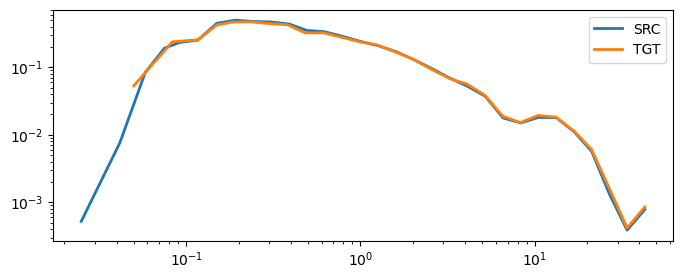

In [71]:
fig, ax = plt.subplots(1, 1, figsize=(8, 3))

x = np.linspace(0, np.max(long_src_dur), 500)

# ax.plot(x, density(x), label="true")

powerlaw.plot_pdf((long_src_dur+1)/60, label="SRC", color=colors[0], linewidth=2)
powerlaw.plot_pdf((long_tgt_dur+1)/60, label="TGT", color=colors[1], linewidth=2)

plt.legend()

plt.show()

## Saving

In [30]:
# sequences
save_pk_file(os.path.join("..", "data", "diff", f"train_level{level}_{src_min_days}_{tgt_min_days}_{data_type}.pk"), valid_train_data)

save_pk_file(os.path.join("..", "data", "diff", f"valid_level{level}_{src_min_days}_{tgt_min_days}_{data_type}.pk"), valid_validation_data)

save_pk_file(os.path.join("..", "data", "diff", f"test_level{level}_{src_min_days}_{tgt_min_days}_{data_type}.pk"), valid_test_data)


In [125]:
# POI

data = {}

data["poiValues"] = np.vstack(poi_df["poiValues"].values)
data["loc_id"] = poi_df["loc_id"].values

np.save(os.path.join("..", "data", "diff", f"poi_level{level}.npy"),data)


## Test reading

In [16]:
loaded = pickle.load(open(os.path.join("..", "data", "diff", f"train_level10_13_{src_min_days}_{tgt_min_days}_tiny.pk"), "rb"))
loaded[0]

{'src': array([10700, 10700, 10516, 10516, 10516, 10700, 11214, 10700, 10700,
        10516, 10700, 10516, 10700, 10700, 10700, 10516, 10700, 11208,
        10516, 11208, 10516, 10517, 10700, 10516, 10700, 10516, 10700,
        10700, 10516], dtype=int64),
 'src_duration': array([ 692,   74,   69,  100,   39,  517,  665, 2324,  455,  626,  823,
         599, 2603,  216,  891,  624,  215,  548,  603,  837,  411,  169,
         918,  616,  811,  626,  910, 1436,  680]),
 'src_user': 1,
 'src_weekday': array([3, 4, 4, 4, 4, 4, 4, 5, 6, 0, 0, 1, 1, 3, 3, 4, 4, 4, 5, 5, 6, 6,
        6, 0, 0, 1, 1, 2, 3]),
 'src_startmin': array([1147,  411,  519,  563,  647,  728, 1224,  448, 1329,  400, 1016,
         403, 1016,  817, 1184,  402, 1017, 1189,  324,  920,  319,  693,
         924,  403, 1015,  405, 1015,  757,  525]),
 'tgt': array([10700, 10516, 10686, 10700, 11208, 10700, 10516, 10516, 10700,
        10700, 12615, 10700, 10516, 10516, 10700, 10516, 10700, 11208,
        10516, 11541, 1120

# Pairwise distance matrix

In [14]:
visited_locs = pd.read_csv("../data/s2_loc_visited_level10_13.csv", index_col="id").sort_values(by="loc_id")
visited_locs["geometry"] = visited_locs["geometry"].apply(wkt.loads)
visited_locs = gpd.GeoDataFrame(visited_locs, geometry="geometry", crs="EPSG:4326")

visited_locs = visited_locs.to_crs("EPSG:2056")

In [15]:
visited_locs.head()

,loc_id,level,geometry,freq,area
id,,,,,
0,5152981090339651584,10,POINT (2824875.045 1159436.528),1,POLYGON ((10.405097146225662 46.50637570678295...
1,5152984577853095936,13,POINT (2822437.857 1167754.527),38,POLYGON ((10.347820052132302 46.61871685680636...
2,5152985265047863296,13,POINT (2815796.126 1167304.569),1,POLYGON ((10.260953592346382 46.61685460820135...
3,5152985299407601664,13,POINT (2816020.303 1168362.492),1,POLYGON ((10.264376293749178 46.62629143145975...
4,5152985505566031872,13,POINT (2818994.419 1169160.037),1,POLYGON ((10.303565033130825 46.63249007077394...


In [16]:
def calculate_distance_matrix(X):
    X = shapely.get_coordinates(X.geometry)

    distance = pdist(X, 'euclidean')
    dist_matrix = squareform(distance)
    return dist_matrix
    
dist_matrix = calculate_distance_matrix(visited_locs)

In [17]:
dist_matrix.shape

(14881, 14881)

In [18]:
save_pk_file("../data/matrix/distance_13.pk", dist_matrix)